In [2]:
import pandas as pd
import numpy as np
import altair as alt
alt.data_transformers.enable('json')
import datetime as dt
from sublimpy import utils
import pytz

# Open SOS Measurement Dataset

In [3]:
ls -lah process_slow_data | grep parquet

-rw-r--r--@    1 elischwat  staff    65M Dec 20 02:09 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags360.parquet
-rw-r--r--@    1 elischwat  staff    66M Jan  3 15:55 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_archive.parquet
-rw-r--r--     1 elischwat  staff    57M Jan 24 21:36 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10.parquet
-rw-r--r--@    1 elischwat  staff    66M Jan 16 17:05 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10_archive.parquet


In [4]:
start_date = '20221101'
end_date = '20230619'

data_start_date = '20221130'
data_end_date = '20230508'
# open files
tidy_df = pd.read_parquet(f'process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10.parquet')
tidy_df = tidy_df.sort_index()
tidy_df = utils.modify_df_timezone(
    tidy_df,
    'UTC',
    'US/Mountain',   
)
tidy_df = tidy_df[tidy_df.time > data_start_date]
tidy_df = tidy_df[tidy_df.time < '20230509']

# Count water vapor flux measurements

In [5]:
['w_h2o__3m_c', 'w_h2o__3m_c_raw', 'w_h2o__3m_c_gapfill']

['w_h2o__3m_c', 'w_h2o__3m_c_raw', 'w_h2o__3m_c_gapfill']

In [6]:
'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__3m_c', 'w_h2o__3m_c', 'w_h2o__3m_c', 'w_h2o__3m_c'

(
    160*48, 
    len(tidy_df.query("variable == 'w_h2o__3m_c_raw'").value), 
    len(tidy_df.query("variable == 'w_h2o__3m_c_raw'").value.dropna()),
    len(tidy_df.query("variable == 'w_h2o__3m_c'").value), 
    len(tidy_df.query("variable == 'w_h2o__3m_c'").value.dropna())
)

(7680, 7677, 7081, 7677, 6998)

In [7]:
160*48, len(tidy_df.query("variable == 'w_h2o__3m_c'").value), len(tidy_df.query("variable == 'w_h2o__3m_c'").value.dropna())

(7680, 7677, 6998)

# Make plot showing cumulative sublimation

In [8]:
seconds_in_timestep = 60*30
from metpy.constants import density_water

In [9]:
rnet_chart_with_axis = alt.Chart(
    tidy_df.query("variable == 'Rnet_9m_d'")
).transform_window(
    frame = [-12, 12],
    rolling_mean = 'mean(value)'
).mark_line(opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("rolling_mean:Q").title(["Net radiation", "(W/m^2)"])
)
rnet_chart_with_axis

alt.Chart(...)

In [10]:
bs_flux_chart = alt.Chart(
    tidy_df[tidy_df.measurement == 'snow flux'].query("value > 0")
).mark_circle(opacity=0.5).encode(
    # alt.X("time:T").axis(labels=False).title(None),
    alt.X("time:T"),
    alt.Y("value:Q").title(["Blowing snow flux", "(g/m²/s)"]).scale(type='log'),
    alt.Color('height:N')
)
bs_flux_chart

alt.Chart(...)

In [11]:
rnet_chart = alt.Chart(
    tidy_df.query("variable == 'RH_3m_c'")
).transform_window(
    frame = [-12, 12],
    rolling_mean = 'mean(value)'
).mark_line(opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
)
rnet_chart


alt.Chart(...)

In [12]:
rnet_chart = alt.Chart(
    tidy_df.query("variable == 'Rnet_9m_d'")
).transform_window(
    frame = [-12, 12],
    rolling_mean = 'mean(value)'
).mark_line(opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("rolling_mean:Q").title(["Net radiation", "(W/m²)"])
)
rnet_chart


alt.Chart(...)

In [13]:
tidy_df.query("measurement == 'SWE'").groupby('variable')['value'].max()

variable
SWE_p1_c    682.850098
SWE_p2_c    436.592560
SWE_p3_c    444.716095
SWE_p4_c    549.908386
Name: value, dtype: float64

In [14]:
tidy_df.query("variable == 'SWE_p_c'").max()

time           NaT
variable       NaN
value          NaN
height         NaN
tower          NaN
measurement    NaN
dtype: object

In [15]:
tidy_df.query("variable == 'SWE_p2_c'").max()

time           2023-05-08 23:30:00
variable                  SWE_p2_c
value                    436.59256
height                         0.0
tower                            c
measurement                    SWE
dtype: object

In [16]:
tidy_df.query("variable == 'SnowDepth_c'").set_index('time').resample('1440Min').value.mean().loc['20230301':].head(46)

time
2023-03-01    0.935503
2023-03-02    0.920480
2023-03-03    0.910108
2023-03-04    0.894254
2023-03-05    0.857450
2023-03-06    0.841127
2023-03-07    0.826282
2023-03-08    0.815563
2023-03-09    0.806782
2023-03-10    1.020137
2023-03-11    1.223900
2023-03-12    1.261439
2023-03-13    1.209115
2023-03-14    1.155336
2023-03-15    1.271245
2023-03-16    1.286076
2023-03-17    1.235735
2023-03-18    1.208993
2023-03-19    1.190249
2023-03-20    1.308915
2023-03-21    1.389292
2023-03-22    1.501851
2023-03-23    1.461231
2023-03-24    1.452047
2023-03-25    1.451125
2023-03-26    1.442971
2023-03-27    1.435833
2023-03-28    1.403136
2023-03-29    1.372657
2023-03-30    1.390106
2023-03-31    1.497692
2023-04-01    1.426832
2023-04-02    1.365400
2023-04-03    1.326226
2023-04-04    1.335187
2023-04-05    1.325650
2023-04-06    1.305411
2023-04-07    1.284790
2023-04-08    1.253708
2023-04-09    1.203678
2023-04-10    1.148427
2023-04-11    1.084945
2023-04-12    1.020029
2023-0

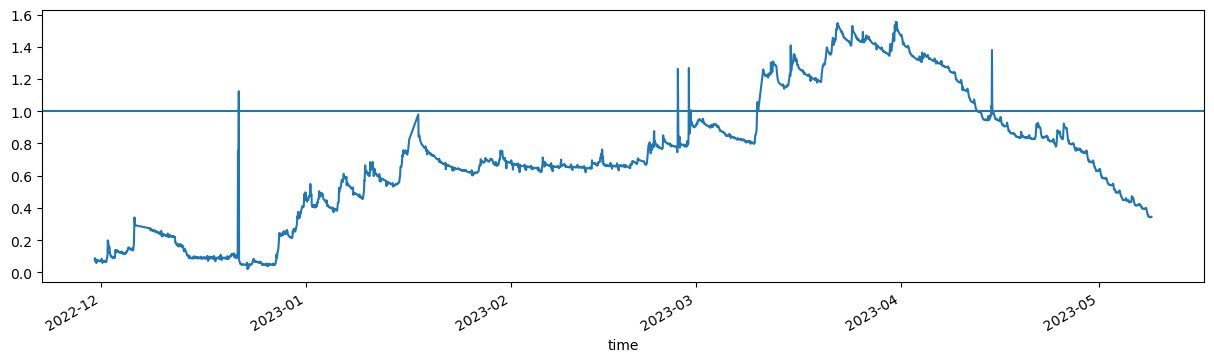

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,4))
tidy_df.query("variable == 'SnowDepth_c'").set_index('time').value.plot()
plt.axhline(1)

In [18]:
tidy_df.query("variable == 'SWE_p2_c'").sort_values('value', ascending=False)

,time,variable,value,height,tower,measurement
3345128,2023-04-08 22:00:00,SWE_p2_c,436.592560,0.0,c,SWE
3345130,2023-04-08 23:00:00,SWE_p2_c,436.489838,0.0,c,SWE
3345129,2023-04-08 22:30:00,SWE_p2_c,436.456604,0.0,c,SWE
3345127,2023-04-08 21:30:00,SWE_p2_c,436.342407,0.0,c,SWE
3345126,2023-04-08 21:00:00,SWE_p2_c,436.237610,0.0,c,SWE
...,...,...,...,...,...,...
3345331,2023-04-13 03:30:00,SWE_p2_c,NaN,0.0,c,SWE
3345332,2023-04-13 04:00:00,SWE_p2_c,NaN,0.0,c,SWE
3345333,2023-04-13 04:30:00,SWE_p2_c,NaN,0.0,c,SWE
3345334,2023-04-13 05:00:00,SWE_p2_c,NaN,0.0,c,SWE


In [19]:
snowpillow_chart = alt.Chart(
    tidy_df.query("variable == 'SWE_p2_c'").dropna()
).transform_window(
    frame = [-48, 48],
    rolling_median = 'median(value)'
).mark_line(color='black').encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("rolling_median:Q").title(["Snow water", "equivalent (mm)"])
).properties(height = 83)
snowpillow_chart

alt.Chart(...)

In [20]:
tidy_df[tidy_df.variable.isin([
        'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c'
    ])][
        tidy_df.time < '20230415'
    ].groupby('variable').value.max()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_52035/1114611917.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[tidy_df.variable.isin([


variable
SWE_p1_c    650.430420
SWE_p2_c    436.592560
SWE_p3_c    444.716095
SWE_p4_c    538.970276
Name: value, dtype: float64

In [21]:
alt.Chart(
    tidy_df[tidy_df.variable.isin([
        'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c'
    ])][
        tidy_df.time < '20230415'
    ]
).transform_window(
    frame = [-48, 48],
    rolling_median = 'median(value)',
    groupby=['variable']
).mark_line(color='black').encode(
    alt.X("time:T"),
    alt.Y("rolling_median:Q").title(["Snow water", "equivalent (mm)"]),
    alt.Color('variable:N')
)


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_52035/3976729874.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[tidy_df.variable.isin([


alt.Chart(...)

In [22]:
tidy_df[tidy_df.variable.isin([
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c'
])].query("time < 20240410")

,time,variable,value,height,tower,measurement
3327807,2022-11-30 00:30:00,SWE_p1_c,28.916878,0.0,uw,SWE
3327808,2022-11-30 01:00:00,SWE_p1_c,28.861050,0.0,uw,SWE
3327809,2022-11-30 01:30:00,SWE_p1_c,28.794594,0.0,uw,SWE
3327810,2022-11-30 02:00:00,SWE_p1_c,28.996391,0.0,uw,SWE
3327811,2022-11-30 02:30:00,SWE_p1_c,29.017145,0.0,uw,SWE
...,...,...,...,...,...,...
3368743,2023-05-08 21:30:00,SWE_p4_c,376.228271,0.0,d,SWE
3368744,2023-05-08 22:00:00,SWE_p4_c,375.930359,0.0,d,SWE
3368745,2023-05-08 22:30:00,SWE_p4_c,375.651611,0.0,d,SWE
3368746,2023-05-08 23:00:00,SWE_p4_c,375.274261,0.0,d,SWE


In [23]:
measured_results_mm = tidy_df[tidy_df.variable.isin([
    'w_h2o__2m_c_gapfill',
    'w_h2o__3m_c_gapfill',
    'w_h2o__5m_c_gapfill',
    'w_h2o__10m_c_gapfill',
    'w_h2o__15m_c_gapfill',
    'w_h2o__20m_c_gapfill',

    'w_h2o__3m_ue_gapfill',
    'w_h2o__10m_ue_gapfill',

    'w_h2o__3m_uw_gapfill',
    'w_h2o__10m_uw_gapfill',

    'w_h2o__3m_d_gapfill',
    'w_h2o__10m_d_gapfill',
])][
    ['time', 'value', 'variable']
]
measured_results_mm.columns = ['time', 'measured', 'variable']
measured_results_mm = measured_results_mm.pivot(
    index = 'time',
    columns = 'variable',
    values = 'measured'
)
# convert to mm
measured_results_mm = measured_results_mm*seconds_in_timestep/density_water.magnitude
measured_results_cumsum = measured_results_mm.cumsum().reset_index()
measured_results_cumsum = measured_results_cumsum.melt(id_vars='time')
measured_results_cumsum['height'] = measured_results_cumsum['variable'].apply(lambda s: int(s.split('__')[1].split('m')[0]))
measured_results_cumsum['tower'] = measured_results_cumsum['variable'].apply(lambda s: s.split('__')[1].split('_')[-2])
measured_results_cumsum['tower-height'] = measured_results_cumsum['tower'] + '-' + measured_results_cumsum['height'].astype('str')

In [24]:
from uncertainties import ufloat

### Average daily sublimation rate

In [25]:
measured_results_mm['w_h2o__10m_c_gapfill'].mean()*48

0.2649826764498827

### Average daily sublimation rate - per month

In [26]:
measured_results_mm.groupby(pd.Grouper(freq='M'))['w_h2o__10m_c_gapfill'].mean()*48

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_52035/2875585159.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  measured_results_mm.groupby(pd.Grouper(freq='M'))['w_h2o__10m_c_gapfill'].mean()*48


time
2022-11-30    0.001684
2022-12-31    0.226025
2023-01-31    0.100278
2023-02-28    0.190189
2023-03-31    0.326569
2023-04-30    0.491608
2023-05-31    0.260006
Freq: ME, Name: w_h2o__10m_c_gapfill, dtype: float64

In [27]:
for var in measured_results_mm.columns:
    print(var)
    sublimation_with_uncertainty_50percent = measured_results_mm[var].apply(
        lambda x: ufloat(x, np.abs(x*0.5))
    )
    final_result_50percent = 0
    for value in sublimation_with_uncertainty_50percent:
        final_result_50percent += value

    sublimation_with_uncertainty_20percent = measured_results_mm[var].apply(
        lambda x: ufloat(x, np.abs(x*0.2))
    )
    final_result_20percent = 0
    for value in sublimation_with_uncertainty_20percent:
        final_result_20percent += value

    print('\tAssuming 20% uncertainty: ', final_result_20percent)
    print('\tAssuming 50% uncertainty: ', final_result_50percent)

w_h2o__10m_c_gapfill
	Assuming 20% uncertainty:  42.38+/-0.26
	Assuming 50% uncertainty:  42.4+/-0.7
w_h2o__10m_d_gapfill
	Assuming 20% uncertainty:  40.02+/-0.28
	Assuming 50% uncertainty:  40.0+/-0.7
w_h2o__10m_ue_gapfill
	Assuming 20% uncertainty:  36.14+/-0.25
	Assuming 50% uncertainty:  36.1+/-0.6
w_h2o__10m_uw_gapfill
	Assuming 20% uncertainty:  40.25+/-0.30
	Assuming 50% uncertainty:  40.2+/-0.7
w_h2o__15m_c_gapfill
	Assuming 20% uncertainty:  33.25+/-0.26
	Assuming 50% uncertainty:  33.2+/-0.6
w_h2o__20m_c_gapfill
	Assuming 20% uncertainty:  34.20+/-0.32
	Assuming 50% uncertainty:  34.2+/-0.8
w_h2o__2m_c_gapfill
	Assuming 20% uncertainty:  34.05+/-0.19
	Assuming 50% uncertainty:  34.0+/-0.5
w_h2o__3m_c_gapfill
	Assuming 20% uncertainty:  37.83+/-0.21
	Assuming 50% uncertainty:  37.8+/-0.5
w_h2o__3m_d_gapfill
	Assuming 20% uncertainty:  39.98+/-0.25
	Assuming 50% uncertainty:  40.0+/-0.6
w_h2o__3m_ue_gapfill
	Assuming 20% uncertainty:  39.85+/-0.23
	Assuming 50% uncertainty:  39

In [28]:
src = tidy_df[tidy_df.variable.isin([
    'w_h2o__2m_c_gapfill',
    'w_h2o__3m_c_gapfill',
    'w_h2o__5m_c_gapfill',
    'w_h2o__10m_c_gapfill',
    'w_h2o__15m_c_gapfill',
    'w_h2o__20m_c_gapfill',
    'w_h2o__3m_ue_gapfill',
    'w_h2o__10m_ue_gapfill',
    'w_h2o__3m_uw_gapfill',
    'w_h2o__10m_uw_gapfill',
    'w_h2o__3m_d_gapfill',
    'w_h2o__10m_d_gapfill',

    'w_h2o__2m_c_raw',
    'w_h2o__3m_c_raw',
    'w_h2o__5m_c_raw',
    'w_h2o__10m_c_raw',
    'w_h2o__15m_c_raw',
    'w_h2o__20m_c_raw',
    'w_h2o__3m_ue_raw',
    'w_h2o__10m_ue_raw',
    'w_h2o__3m_uw_raw',
    'w_h2o__10m_uw_raw',
    'w_h2o__3m_d_raw',
    'w_h2o__10m_d_raw',

    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
    'w_h2o__3m_ue',
    'w_h2o__10m_ue',
    'w_h2o__3m_uw',
    'w_h2o__10m_uw',
    'w_h2o__3m_d',
    'w_h2o__10m_d',
])][
    ['time', 'value', 'variable']
].set_index('time').sort_index()

from sublimpy import tidy
src['tower'] = src.variable.apply(lambda s: s.replace('_raw', '').replace('_gapfill', '')).apply(
    tidy._tower_from_variable_name
)
src['height'] = src.variable.str.replace('_raw', '').replace('_gapfill', '').apply(
    tidy._height_from_variable_name
)

def label_variable(v):
    if 'raw' in v:
        return 'raw'
    elif 'gapfill' in v:
        return 'gapfill'
    else:
        return 'cleaned'
src['data_processing'] = src.variable.apply(label_variable)

alt.Chart(src.dropna()).mark_bar().encode(
    alt.Row('tower:N'),
    alt.Column('height:Q'),
    alt.Y('sum(value):Q'),
    alt.X('data_processing:N')
).properties(height=50)

alt.Chart(...)

In [29]:
cum_sub_chart = alt.Chart(measured_results_cumsum.dropna()).transform_filter(
    alt.datum.height > 1
).mark_line(strokeWidth=1.5).transform_window(
    rolling_median = "median(value)",
    groupby = ["height", "tower-height"],
    frame=[-2,2]
).encode(
    alt.X("time:T"),
    alt.Y("rolling_median:Q").title("Cumulative sublimation (mm)"),
    alt.Color("height:O").scale(scheme = 'turbo').title('Height (m)'),
    detail = "tower-height"
)

cum_sub_chart_no_xaxislabels = alt.Chart(measured_results_cumsum.dropna()).transform_filter(
    alt.datum.height > 1
).mark_line(strokeWidth=1.5).transform_window(
    rolling_median = "median(value)",
    groupby = ["height", "tower-height"],
    frame=[-2,2]
).encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("rolling_median:Q").title("Cumulative sublimation (mm)"),
    alt.Color("height:O").scale(scheme = 'turbo').title('Height (m)'),
    detail = "tower-height"
)

In [30]:
selection = alt.selection_point(fields=['tower-height'], bind='legend', toggle=True)
src = measured_results_cumsum.dropna().query("height > 1")
chart = alt.Chart(src).mark_line(strokeWidth=1.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Cumulative sublimation (mm)"),
    alt.Color("tower-height:N").scale(scheme = 'turbo'),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.0))
).add_params(
    selection
).properties(width=600, height=300).interactive()
chart.save("/Users/elischwat/Downloads/cumulative_sublimation_interactive.html", scale_factor=10)

In [31]:
cum_sub_and_snowpack_swe_chart = (snowpillow_chart & cum_sub_chart).resolve_scale(
    x='shared', y='independent', color='independent'
)

cum_sub_and_snowpack_swe_chart.save("cum-sub-and-snowpack-swe.png", ppi=200)
cum_sub_and_snowpack_swe_chart

alt.VConcatChart(...)

# Make plot showing daily sublimation by clear/blowing snow 

## Calculate daily sublimation

In [32]:
import metpy.constants
seconds_per_timestep = 60*30

In [33]:
daily_sub_by_blowingsnow_src = tidy_df[
    tidy_df.variable.isin(['w_h2o__3m_c_gapfill', 'SF_avg_1m_ue', 'SF_avg_2m_ue'])
].pivot_table(
    values = 'value',
    index = 'time',
    columns = 'variable'
)
daily_sub_by_blowingsnow_src['SF_avg_max_ue'] = daily_sub_by_blowingsnow_src[['SF_avg_1m_ue', 'SF_avg_2m_ue']].max(axis=1)
daily_sub_by_blowingsnow_src['blowing snow'] = daily_sub_by_blowingsnow_src['SF_avg_max_ue'] > 0
daily_sub_by_blowingsnow_src['Sublimation (mm)'] = daily_sub_by_blowingsnow_src[
    'w_h2o__3m_c_gapfill'
]*seconds_per_timestep / metpy.constants.density_water.magnitude# calculate daily sublimation
daily_sub_by_blowingsnow_src = daily_sub_by_blowingsnow_src.groupby([pd.Grouper(freq='1440Min'), 'blowing snow']).sum()
daily_sub_by_blowingsnow_src = daily_sub_by_blowingsnow_src.reset_index()
daily_sub_by_blowingsnow_src

variable,time,blowing snow,SF_avg_1m_ue,SF_avg_2m_ue,w_h2o__3m_c_gapfill,SF_avg_max_ue,Sublimation (mm)
0,2022-11-30,False,0.000000,0.000000,-0.021462,0.000000,-0.038632
1,2022-12-01,False,0.000000,0.000000,0.055566,0.000000,0.100022
2,2022-12-02,False,0.000000,0.000000,-0.000950,0.000000,-0.001711
3,2022-12-02,True,3.015333,3.996667,0.205003,4.093667,0.369015
4,2022-12-03,False,0.000000,0.000000,0.031067,0.000000,0.055922
...,...,...,...,...,...,...,...
261,2023-05-05,True,0.000000,0.001667,0.010942,0.001667,0.019696
262,2023-05-06,False,0.000000,0.000000,0.390320,0.000000,0.702593
263,2023-05-06,True,0.063333,0.121667,-0.001098,0.123333,-0.001977
264,2023-05-07,False,0.000000,0.000000,0.131095,0.000000,0.235976


## Plot

In [34]:
daily_sub_chart = alt.Chart(daily_sub_by_blowingsnow_src).mark_bar(width=2.5).encode(
    alt.X("time:T", title=None).axis(labels=False),
    alt.Y("Sublimation (mm):Q").title(["Daily sublimation", "(mm)"]), 
    alt.Color("blowing snow:N").scale(domain=[True, False], range=['#000000', '#C0C0C0']).title(
        'Blowing snow'
    ),
    tooltip='time:T'
).properties(height = 100, width=500)

In [35]:
(daily_sub_chart).resolve_scale(y='independent').configure_axis(grid=False)

alt.Chart(...)

# Make stability regime hovmoller plot

## Using temp gradient (pot virtal temp gradient)

In [36]:
src = tidy_df.query("variable == 'temp_gradient_3m_c'")
src = src.assign(hour = src.time.dt.hour)
src = src.assign(hour_end = src.time.dt.hour + 1)
src = src.assign(start_date = src.time.apply(lambda dt_p: dt_p.replace(hour=0,minute=0,second=0)))
src = src.assign(end_date = src.time.apply(lambda dt_p: dt_p.replace(hour=0,minute=0,second=0) + dt.timedelta(hours=24)))
src = src.groupby([
    'hour',
    'hour_end',
    'start_date',
    'end_date',
])[['value']].median().reset_index()

# this makes it easy to make a custom colorscale with 
# negative values as a drastically different color
# round for values that are equal to or greater than 0 (stable cases)
stable_src = src[src.value >= -0.01]
stable_src['value'] = stable_src['value'].round(1)

unstable_src = src[src.value < -0.01]
unstable_src['value'] = -0.1

src = pd.concat([stable_src, unstable_src])

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_52035/836200928.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stable_src['value'] = stable_src['value'].round(1)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_52035/836200928.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unstable_src['value'] = -0.1


In [37]:
domain = np.linspace(-0.1,0.8, 10).round(1)
range = [
    '#ff2600', #red
    '#ffffff', #blue scale, increasinlgy blue
    '#e6ebfc',
    '#cbd8f9',
    '#aec4f6',
    '#90b0f4',
    '#7199f3',
    '#4f80f2',
    '#2a62f4',
    '#0433ff',    
]
tempgrad_hovmoller_plot = alt.Chart(src.dropna()).mark_rect().encode(
        alt.X("start_date:T").title("date"),
        alt.X2("end_date:T"),
        alt.Y("hour:Q").title(['Hour of day']).scale(reverse=True).axis(values=[0,6,12,18,24]),
        alt.Y2("hour_end:Q"),
        alt.Color("value:O").scale(domain=domain, range=range).title(['Static Stability', '(dθᵥ /dz, ˚C/m)'])
).properties(height = 100, width=500)
tempgrad_hovmoller_plot

alt.Chart(...)

In [38]:
src = tidy_df[tidy_df.variable.isin(['u*_3m_c', 'Tsurfvirtual_c', 'Tvirtual_1m_c', 'Tvirtual_2m_c', 'Tvirtual_3m_c','w_tc__3m_c',])].pivot_table(index='time', columns='variable', values='value')
src['Tvirtual_avg'] = src[['Tsurfvirtual_c', 'Tvirtual_3m_c']].mean(axis=1)
l_3m_c = - (src['u*_3m_c']**3)*(src['Tvirtual_avg']+273.15) / (0.4 * 9.81 * src['w_tc__3m_c'])
src = pd.DataFrame(l_3m_c.rename('L_3m_c')).reset_index()
src['zeta'] = 3 / src['L_3m_c']
src = src.assign(hour = src.time.dt.hour)
src = src.assign(hour_end = src.time.dt.hour + 1)
src = src.assign(start_date = src.time.apply(lambda dt_p: dt_p.replace(hour=0,minute=0,second=0)))
src = src.assign(end_date = src.time.apply(lambda dt_p: dt_p.replace(hour=0,minute=0,second=0) + dt.timedelta(hours=24)))
src = src.groupby([
    'hour',
    'hour_end',
    'start_date',
    'end_date',
])[['zeta']].median().reset_index()
src

,hour,hour_end,start_date,end_date,zeta
0,0,1,2022-11-30,2022-12-01,0.064895
1,0,1,2022-12-01,2022-12-02,-0.133571
2,0,1,2022-12-02,2022-12-03,0.036050
3,0,1,2022-12-03,2022-12-04,-0.151515
4,0,1,2022-12-04,2022-12-05,-0.254288
...,...,...,...,...,...
3824,23,24,2023-05-04,2023-05-05,0.254038
3825,23,24,2023-05-05,2023-05-06,0.252681
3826,23,24,2023-05-06,2023-05-07,0.032669
3827,23,24,2023-05-07,2023-05-08,0.134733


In [39]:
alt.Chart(src).mark_bar().encode(
    alt.X('zeta:Q').bin(step=1),
    alt.Y('count():Q')
)

alt.Chart(...)

In [40]:
alt.Chart(src.dropna()).mark_rect().encode(
        alt.X("start_date:T").title("date"),
        alt.X2("end_date:T"),
        alt.Y("hour:Q").title(['Hour of day']).scale(reverse=True).axis(values=[0,6,12,18,24]),
        alt.Y2("hour_end:Q"),
        alt.Color("zeta:Q").scale(domain=[-1,1], clamp=True, scheme='purpleorange')
).properties(height = 100, width=500)


alt.Chart(...)

## Using Ri_3m_c

In [41]:
src = tidy_df.query("variable == 'Ri_3m_c'")
src = src.assign(hour = src.time.dt.hour)
src = src.assign(hour_end = src.time.dt.hour + 1)
src = src.assign(start_date = src.time.apply(lambda dt_p: dt_p.replace(hour=0,minute=0,second=0)))
src = src.assign(end_date = src.time.apply(lambda dt_p: dt_p.replace(hour=0,minute=0,second=0) + dt.timedelta(hours=24)))
src = src.groupby([
    'hour',
    'hour_end',
    'start_date',
    'end_date',
])[['value']].median().reset_index()
# this makes it easy to make a custom colorscale with 
# negative values as a drastically different color
src['value'] = src['value'].round(1)

In [42]:
alt.Chart(src.dropna()).mark_rect().encode(
        alt.X("start_date:T"),
        alt.X2("end_date:T"),
        alt.Y("hour:Q"),
        alt.Y2("hour_end:Q"),
        alt.Color("value:Q").scale(scheme='blueorange', domain=[-1,1.0])
).properties(height = 100, width=500).configure_axis(grid=False)

alt.Chart(...)

## Using $\Omega_{3m}^c$

In [43]:
src = tidy_df.query("variable == 'omega_3m_c'")
src = src.assign(hour = src.time.dt.hour)
src = src.assign(hour_end = src.time.dt.hour + 1)
src = src.assign(start_date = src.time.apply(lambda dt_p: dt_p.replace(hour=0,minute=0,second=0)))
src = src.assign(end_date = src.time.apply(lambda dt_p: dt_p.replace(hour=0,minute=0,second=0) + dt.timedelta(hours=24)))
src = src.groupby([
    'hour',
    'hour_end',
    'start_date',
    'end_date',
])[['value']].median().reset_index()
# this makes it easy to make a custom colorscale with 
# negative values as a drastically different color
src['value'] = src['value'].round(1)

In [44]:
alt.Chart(src.dropna()).mark_rect().encode(
        alt.X("start_date:T"),
        alt.X2("end_date:T"),
        alt.Y("hour:Q"),
        alt.Y2("hour_end:Q"),
        alt.Color("value:Q").scale(scheme='blueorange', domain=[0, .86], clamp=True),
).properties(height = 100, width=500).configure_axis(grid=False)

alt.Chart(...)

In [45]:
src = tidy_df[tidy_df.variable.isin([
    'omega_3m_c',
    'Ri_3m_c',
    'temp_gradient_3m_c',
])][['time', 'variable', 'value']].pivot(index='time', columns='variable')
src.columns = src.columns.droplevel(0)

coupled_rule = alt.Chart(pd.DataFrame({'x':[0.43]})).mark_rule().encode(y='x')

base_chart = alt.Chart(
    src.groupby(pd.Grouper(freq='60Min')).median()
).mark_circle(
    size=5,
    opacity=0.25
)
alt.Chart(
    src.groupby(pd.Grouper(freq='60Min')).median()
).mark_circle(
    size=10,
    opacity=0.25
).properties(width = 200, height = 200)
omega_yaxis = alt.Y('omega_3m_c:Q').scale(domain=[0,5], clamp=True)
ri_xaxis = alt.X("Ri_3m_c:Q").scale(domain=[-0.5,0.5], clamp=True)

omega_vs_ri = base_chart.encode(
    ri_xaxis,
    omega_yaxis,
) + coupled_rule
tempgrad_vs_ri = base_chart.encode(
    ri_xaxis,
    alt.Y('temp_gradient_3m_c:Q'),
)
omega_vs_tempgrad = base_chart.encode(
    alt.X("temp_gradient_3m_c:Q"),
    omega_yaxis,
) + coupled_rule
omega_vs_ri | tempgrad_vs_ri | omega_vs_tempgrad

alt.HConcatChart(...)

# Make stability regime time series plot

In [46]:
def temp_gradient_to_stability_regime(x):
    if np.isnan(x):
        return None
    elif x < -0.01:
        return "unstable"
    elif x >= -0.01 and x <= 0.01:
        return "neutral"
    elif x > 0.01:
        return "stable"
    else:
        raise ValueError("what?")
src = tidy_df.query("variable == 'temp_gradient_3m_c'")
src['date'] = src.time.dt.date
src[src.time.dt.hour.isin([0,1])]
src_day = src[src.time.dt.hour.isin([12,13])].assign(time_of_day = 'day')
src_night = src[src.time.dt.hour.isin([0,1])].assign(time_of_day = 'night')
src = pd.concat([src_day, src_night])
src = src.groupby(['date', 'time_of_day']).mean(numeric_only=True).reset_index()
src['stability regime'] = src['value'].apply(temp_gradient_to_stability_regime)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_52035/2887523614.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['date'] = src.time.dt.date


In [47]:
stability_regime_chart = alt.Chart(src).mark_bar().encode(
    alt.X("date:T"),
    alt.Color("stability regime:N").scale(domain = ['neutral', 'stable', 'unstable'], range=['#000000', '#1f77b4', '#ff7f0e']  ),
    alt.Y("time_of_day:N", sort=['night', 'day'], title=None)
).properties(width = 500)

In [48]:
src = tidy_df[tidy_df.measurement.isin([
    'virtual temperature',
    'surface virtual temperature'
])]
src = src.set_index("time").groupby([pd.Grouper(freq='60Min'), 'height']).mean(numeric_only=True).reset_index()
src['hour'] = src.time.dt.hour
src = src[src['hour']%4 == 0]

def profile_chart(src):
    return alt.Chart(src).mark_line().encode(
        alt.X("value:Q").title("Virtual temperature (˚C)"),
        alt.Y("height:Q").title("Height (m)"),
        alt.Color('hour:O').scale(scheme='rainbow').title('Hour'),
        order='height'
    ).properties(width = 200, height = 125)

In [49]:
alt.Chart(
    src[src.time < '20230320'].query("height != 15").query("height != 1")
).mark_line().encode(
    alt.X("median(value):Q").title("Virtual temperature (˚C)"),
    alt.Y("height:Q").title("Height (m)"),
    alt.Color('hour:O').scale(scheme='rainbow').title('Hour'),
    order='height'
).properties(width = 200, height = 125) | alt.Chart(
    src[src.time >= '20230320'].query("height != 15").query("height != 1")
).mark_line().encode(
    alt.X("median(value):Q").title("Virtual temperature (˚C)"),
    alt.Y("height:Q").title("Height (m)"),
    alt.Color('hour:O').scale(scheme='rainbow').title('Hour'),
    order='height'
).properties(width = 200, height = 125)

alt.HConcatChart(...)

In [50]:
profiles_chart = (
    profile_chart(
        src[
            src.time.dt.date == dt.date(2023, 2, 11)
        ].dropna().query("height != 15")
    ).properties(title = "Sunny, midwinter day (2023-02-11)")
    |
    profile_chart(
        src[
            src.time.dt.date == dt.date(2023, 3, 28)
        ].dropna().query("height != 15")
    ).properties(title = "Sunny, spring day (2023-03-28)")
).resolve_scale(x='shared', y='shared')
profiles_chart

alt.HConcatChart(...)

In [51]:
grad_exam_chart = (    
    (
        cum_sub_chart_no_xaxislabels.properties(height = 200) & 
        daily_sub_chart & 
        rnet_chart.properties(height = 75) & 
        tempgrad_hovmoller_plot
    ).resolve_scale(color='independent', x='shared')
).configure_legend(symbolSize=50, labelFontSize=10, rowPadding=1)

grad_exam_chart.save("gradexam_seasonal_conditions_figure.png", ppi=200)

In [52]:
wsc_chart = (    
    (
        (snowpillow_chart + cum_sub_chart_no_xaxislabels).resolve_scale(y='independent').properties(
            height = 200, width=500) & 
        daily_sub_chart.properties(height = 75) & 
        rnet_chart.properties(height = 75, width=500)
        # &  tempgrad_hovmoller_plot
    ).resolve_scale(color='independent', x='shared')
    # &
    # profiles_chart
).configure_legend(symbolSize=50, labelFontSize=10, rowPadding=1)

wsc_chart.save("../../figures/seasonal_sublimation_and_conditions.png", ppi=200)
wsc_chart

alt.VConcatChart(...)

In [53]:
(
    alt.Chart(
        tidy_df.query("measurement == 'snow flux'").query("time < '20230118'").query    ("time > '20230117'")
    ).mark_circle().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('BS flux (g/m^2/s)'),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(height = 100, width=200) & alt.Chart(
        tidy_df[tidy_df.variable.isin([
            'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c'
        ])].query("time < '20230118'").query("time > '20230117'")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title("w'q' (g/m^2/s)").scale(domain=[-0.0001,0.1], clamp=True),
        alt.Color('height:O').scale(scheme='turbo'),
        tooltip='height'
    ).properties(height = 100, width=200) & 
    alt.Chart(
        tidy_df[tidy_df.variable.isin([
            'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c'
        ])].query("time < '20230118'").query    ("time > '20230117'")
    ).transform_window(
            sort=[{'field': 'time'}],
        # Include all previous records before the current record and none after
        # (This is the default value so you could skip it and it would still work.)
        frame=[None, 0],
        # What to add up as you go
        cumulative_flux_density='sum(value)',
        groupby=['height']
    ).transform_calculate(
        cumulative_sub_mm = 'datum.cumulative_flux_density * 1800 / 1000'
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('cumulative_sub_mm:Q').title(['Cumulative', 'sublimation (mm)']),
        alt.Color('height:O').scale(scheme='turbo')
).properties(height = 100, width=200)
)  |\
(
    alt.Chart(
    tidy_df[tidy_df.variable.isin([
        'ldiag_3m_c', 'ldiag_5m_c', 'ldiag_10m_c', 'ldiag_15m_c', 'ldiag_20m_c'
    ])].query("time < '20230118'").query("time > '20230117'")
).mark_line().transform_calculate(
    percent_flagged = "100 * datum.value/6000"
).encode(
    alt.X('time:T'),
    alt.Y('percent_flagged:Q').title(['sonic diagnostic', '(% flagged)'] ),
    alt.Color('height:O').scale(scheme='turbo'),
    tooltip='height'
).properties(height = 100, width=200) &
    alt.Chart(
        tidy_df[tidy_df.variable.isin([
            'irgadiag_3m_c', 'irgadiag_5m_c', 'irgadiag_10m_c', 'irgadiag_15m_c', 'irgadiag_20m_c'
        ])].query("time < '20230118'").query("time > '20230117'")
    ).mark_line().transform_calculate(
        percent_flagged = "100 * datum.value/6000"
    ).encode(
        alt.X('time:T'),
        alt.Y('percent_flagged:Q').title(['irgason diagnostic', '(% flagged)'] ),
        alt.Color('height:O').scale(scheme='turbo'),
        tooltip='height'
    ).properties(height = 100, width=200) & alt.Chart(
        tidy_df[tidy_df.variable.isin([
            'spd_3m_c', 'spd_5m_c', 'spd_10m_c', 'spd_20m_c'
        ])].query("time < '20230118'").query("time > '20230117'")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('wind speed (m/s)'),
        alt.Color('height:O').scale(scheme='turbo'),
        tooltip='height'
    ).properties(height = 100, width=200)
)

alt.HConcatChart(...)

In [54]:
tidy_df[tidy_df.measurement == 'wind speed'].groupby('variable').max()

,time,value,height,tower,measurement
variable,,,,,
spd_10m_c,2023-05-08 23:30:00,18.185080,10.0,c,wind speed
spd_10m_d,2023-05-08 23:30:00,17.661438,10.0,d,wind speed
spd_10m_ue,2023-05-08 23:30:00,18.047527,10.0,ue,wind speed
spd_10m_uw,2023-05-08 23:30:00,18.152956,10.0,uw,wind speed
spd_15m_c,2023-05-08 23:30:00,18.049135,15.0,c,wind speed
spd_1m_c,2023-05-08 23:30:00,13.478688,1.0,c,wind speed
spd_1m_d,2023-05-08 23:30:00,36.202965,1.0,d,wind speed
spd_1m_ue,2023-05-08 23:30:00,11.033652,1.0,ue,wind speed
spd_1m_uw,2023-05-08 23:30:00,6.322706,1.0,uw,wind speed


In [55]:
tidy_df[tidy_df.measurement == 'wind speed'].set_index('time').loc['20221222'].groupby('variable').max()

,value,height,tower,measurement
variable,,,,
spd_10m_c,18.185080,10.0,c,wind speed
spd_10m_d,17.661438,10.0,d,wind speed
spd_10m_ue,18.047527,10.0,ue,wind speed
spd_10m_uw,18.152956,10.0,uw,wind speed
spd_15m_c,18.049135,15.0,c,wind speed
spd_1m_c,13.478688,1.0,c,wind speed
spd_1m_d,36.202965,1.0,d,wind speed
spd_1m_ue,11.033652,1.0,ue,wind speed
spd_1m_uw,6.164642,1.0,uw,wind speed


In [56]:
src = measured_results_cumsum.groupby(['height', 'tower'])[['value']].max().reset_index()
sublimation_totals_per_height_tower_chart = alt.Chart(src).mark_point(size=100).encode(
    alt.Y("height:O").sort('-y').title("Height (m)"),
    alt.X("value:Q").scale(zero=False).title(["Seasonal sublimation (mm SWE)"]),
    # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
    alt.Shape("tower:N")
).properties(width = 150, height = 150)
sublimation_totals_per_height_tower_chart.save('../../figures/sublimation_per_tower_and_height.png', ppi = 200)
sublimation_totals_per_height_tower_chart

alt.Chart(...)

In [65]:
round(
    src.sort_values('value').query('height == 3').value.mean(), 
    1
), round(
    src.sort_values('value').query('height == 3').value.std(),
    1
), round(
    src.sort_values('value').query('height == 10').value.mean(), 
    1
), round(
    src.sort_values('value').query('height == 10').value.std(),
    1
)

(38.9, 1.1, 39.7, 2.6)

In [57]:
print(len(measured_results_cumsum.time.unique()))

7677


In [58]:
# Identify lists of timestamps for different categories
bs_times = set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
)
nobs_times = set(tidy_df.time).difference(bs_times)

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 152").query("value > 92").time.values
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 342").query("value > 292").time.values
len(upvalley_wind_times),len(downvalley_wind_times)

(1409, 3890)

In [59]:
total_3m = measured_results_mm['w_h2o__10m_c_gapfill'].sum() 
total_10m = measured_results_mm['w_h2o__3m_c_gapfill'].sum()
total_blend = (measured_results_mm[measured_results_mm.index.isin(bs_times)]['w_h2o__10m_c_gapfill'].sum() + 
    measured_results_mm[measured_results_mm.index.isin(nobs_times)]['w_h2o__3m_c_gapfill'].sum())

In [60]:
round(total_3m, 1), round(total_10m, 1), round(total_blend, 1)

(42.4, 37.8, 42.9)

In [61]:
src = measured_results_mm.melt(ignore_index=False)
src['tower'] = src['variable'].apply(
    lambda str: str.replace('_gapfill', '').split('_')[-1]
)
src['height'] = src['variable'].apply(
    lambda str: int(str.split('m_')[0].split('__')[-1])
)


In [62]:
from astral import LocationInfo
from suntime import Sun
from zoneinfo import ZoneInfo

# On a special date in your machine's local time zone
sun = Sun(38.957984, -106.988687)
def assign_bs_and_daytime_label(this_time):
    label = ''
    utc_aware = this_time.replace(tzinfo=ZoneInfo('US/Mountain'))  # make aware
    sunrise = sun.get_sunrise_time(this_time, time_zone=pytz.timezone('US/Mountain')).replace(tzinfo=None)
    sunset = sun.get_sunset_time(this_time, time_zone=pytz.timezone('US/Mountain')).replace(tzinfo=None)
    if sunrise > sunset:
        sunset = sunset + dt.timedelta(days=1)
    
    if this_time in bs_times:
        label += 'BS'
    else:
        label += 'No BS'
    if (this_time > sunrise) & (this_time < sunset):
        label += ', Daytime'
    else:
        label += ', Nighttime'
    if label.startswith('BS'):
        label = 'BS'
    return label


In [63]:
src = src.reset_index().assign(conditions = src.reset_index().time.apply(assign_bs_and_daytime_label))

In [64]:
src.value.min(), src.value.max(), src.value.median()

(-0.3530373584008809, 0.38698274529330673, 0.0011335241753179233)

In [65]:
print(len(src.query("conditions == 'No BS, Nighttime'").time.unique()))
print(len(src.query("conditions == 'No BS, Daytime'").time.unique()))
print(len(src.query("conditions == 'BS'").time.unique()))

3323
2658
1696


In [66]:
sublimation_totals_per_height_tower_chart.properties(title='Total sublimation') |\
(alt.Chart(src.query("conditions == 'No BS, Nighttime'")).mark_point(size=100).encode(
    alt.Y("height:O").sort('-y').title("Height (m)"),
    alt.X("mean(value):Q").scale(zero=False).title(["Water vapor flux (g/m^2/s)"]),
    # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
    alt.Shape("tower:N")
).properties(title = ['Mean sublimation rate', 'during No BS, Night'], width = 150, height = 150) |\
alt.Chart(src.query("conditions == 'No BS, Daytime'")).mark_point(size=100).encode(
    alt.Y("height:O").sort('-y').title("Height (m)"),
    alt.X("mean(value):Q").scale(zero=False).title(["Water vapor flux (g/m^2/s)"]),
    # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
    alt.Shape("tower:N")
).properties(title = ['Mean sublimation rate', 'during No BS, Daytime'], width = 150, height = 150) |\
alt.Chart(src.query("conditions == 'BS'")).mark_point(size=100).encode(
    alt.Y("height:O").sort('-y').title("Height (m)"),
    alt.X("mean(value):Q").scale(zero=False).title(["Water vapor flux (g/m^2/s)"]),
    # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
    alt.Shape("tower:N")
).properties(title=['Mean sublimation rate', 'during BS'], width = 150, height = 150)).resolve_scale(x='shared', y='shared')

alt.HConcatChart(...)

In [67]:
from metpy.units import units
from metpy.constants import density_ice
density_ice

<Quantity(917, 'kilogram / meter ** 3')>

In [68]:
src.value = (src['value'].values * units('g/m^2/s') / density_ice).to_base_units().to("mm/hour")

In [69]:
sublimation_totals_per_height_tower_chart.properties(title='Total seasonal sublimation') |\
(alt.Chart(src.query("conditions == 'No BS, Nighttime'")).mark_point(size=100).encode(
    alt.Y("height:O").sort('-y').title("Height (m)"),
    alt.X("mean(value):Q").scale(zero=False).title(["Water vapor flux (mm/hr)"]),
    # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
    alt.Shape("tower:N")
).properties(title = ['Mean sublimation rate', 'during No BS, Night'], width = 150, height = 150) |\
alt.Chart(src.query("conditions == 'No BS, Daytime'")).mark_point(size=100).encode(
    alt.Y("height:O").sort('-y').title("Height (m)"),
    alt.X("mean(value):Q").scale(zero=False).title(["Water vapor flux (mm/hr)"]),
    # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
    alt.Shape("tower:N")
).properties(title = ['Mean sublimation rate', 'during No BS, Daytime'], width = 150, height = 150) |\
alt.Chart(src.query("conditions == 'BS'")).mark_point(size=100).encode(
    alt.Y("height:O").sort('-y').title("Height (m)"),
    alt.X("mean(value):Q").scale(zero=False).title(["Water vapor flux (mm/hr)"]),
    # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
    alt.Shape("tower:N")
).properties(title=['Mean sublimation rate', 'during BS'], width = 150, height = 150)).resolve_scale(x='shared', y='shared')

alt.HConcatChart(...)

In [70]:
src.query("conditions == 'No BS, Daytime'").groupby('variable').value.mean()

variable
w_h2o__10m_c_gapfill     0.022727
w_h2o__10m_d_gapfill     0.022394
w_h2o__10m_ue_gapfill    0.018857
w_h2o__10m_uw_gapfill    0.022435
w_h2o__15m_c_gapfill     0.015028
w_h2o__20m_c_gapfill     0.016301
w_h2o__2m_c_gapfill      0.024199
w_h2o__3m_c_gapfill      0.025355
w_h2o__3m_d_gapfill      0.027734
w_h2o__3m_ue_gapfill     0.026218
w_h2o__3m_uw_gapfill     0.026757
w_h2o__5m_c_gapfill      0.025139
Name: value, dtype: float64

In [71]:
1 - src.query("conditions == 'No BS, Daytime'").groupby('variable').value.mean()['w_h2o__10m_c_gapfill'] / \
src.query("conditions == 'No BS, Daytime'").groupby('variable').value.mean()['w_h2o__3m_c_gapfill']

0.10364344587914087

In [72]:
1 - src.query("conditions == 'No BS, Daytime'").groupby('variable').value.mean()['w_h2o__15m_c_gapfill'] / \
src.query("conditions == 'No BS, Daytime'").groupby('variable').value.mean()['w_h2o__3m_c_gapfill']

0.40730938392777294

In [73]:
1 - src.query("conditions == 'No BS, Daytime'").groupby('variable').value.mean()['w_h2o__20m_c_gapfill'] / \
src.query("conditions == 'No BS, Daytime'").groupby('variable').value.mean()['w_h2o__3m_c_gapfill']

0.35709369583750816

In [74]:
bs_data = tidy_df[tidy_df.variable.isin(["SF_avg_1m_ue", "SF_avg_2m_ue"])].pivot_table(
    index='time',
    values='value',
    columns = 'variable'
)
bs_data['SF_avg_ue'] = (bs_data['SF_avg_1m_ue'] + bs_data['SF_avg_2m_ue'])/2

In [75]:

src = src.set_index('time').join(bs_data[['SF_avg_ue']])
src = src.query("SF_avg_ue > 0").query("tower == 'c'")

In [76]:
src['SF_avg_bin'] = pd.cut(src['SF_avg_ue'], bins=[0,0.01,0.1,1,10,100]).apply(
    lambda range: str(range)[1:-1].replace(', ', '-')
)

In [77]:
src

,variable,value,tower,height,conditions,SF_avg_ue,SF_avg_bin
time,,,,,,,
2022-12-02 01:30:00,w_h2o__10m_c_gapfill,0.012906,c,10,BS,0.005000,0.0-0.01
2022-12-02 02:00:00,w_h2o__10m_c_gapfill,0.003434,c,10,BS,0.030000,0.01-0.1
2022-12-02 02:30:00,w_h2o__10m_c_gapfill,0.001003,c,10,BS,0.015000,0.01-0.1
2022-12-02 03:00:00,w_h2o__10m_c_gapfill,0.033118,c,10,BS,0.003333,0.0-0.01
2022-12-02 03:30:00,w_h2o__10m_c_gapfill,0.014757,c,10,BS,0.001667,0.0-0.01
...,...,...,...,...,...,...,...
2023-05-05 15:00:00,w_h2o__5m_c_gapfill,0.092525,c,5,BS,0.000833,0.0-0.01
2023-05-06 04:30:00,w_h2o__5m_c_gapfill,0.043715,c,5,BS,0.090000,0.01-0.1
2023-05-06 05:00:00,w_h2o__5m_c_gapfill,-0.006790,c,5,BS,0.000833,0.0-0.01


In [78]:
src['log_SF_avg_ue'] = np.log10(src['SF_avg_ue'])
bs_measurement_distribution = alt.Chart(
    src[['log_SF_avg_ue', 'SF_avg_bin']].reset_index().drop_duplicates()
).mark_bar().encode(
    alt.X("log_SF_avg_ue:Q").bin(True).title('log[BS Flux (g/m^2/s)]'),
    alt.Y("count():Q"),
    # alt.Color('log_SF_avg_ue:O').bin(True).scale(scheme='turbo')
    alt.Color('SF_avg_bin:O').scale(scheme='turbo')
).properties(title=['Distribution of BS Fluxes'], width = 150, height = 150).resolve_scale(x='independent')

turb_fluxdiv_during_bs = alt.Chart(
    src
).mark_line(point=True).encode(
    alt.X("mean(value):Q").scale(zero=False).title(["Water vapor flux (mm/hr)"]),
    alt.Y("height:Q").sort('-y').title("Height (m)"),
    alt.Color("SF_avg_bin:O").scale(scheme='turbo').title('BS Flux Bin (g/m^2/s)'),
    order = 'height',
).properties(title=['Mean EC verical water', ' vapor fluxes during BS'], width = 150, height = 150)

bs_measurement_distribution | turb_fluxdiv_during_bs

alt.HConcatChart(...)

In [79]:
# src_mixing_ratio = tidy_df[tidy_df.measurement == "RH"].query("tower == 'c'").set_index('time').join(
src_mixing_ratio = tidy_df[tidy_df.measurement == "mixing ratio"].query("tower == 'c'").set_index('time').join(
    src['SF_avg_bin']
)
src_mixing_ratio = src_mixing_ratio.dropna(subset=['SF_avg_bin'])
src_mixing_ratio = src_mixing_ratio[(src_mixing_ratio.height != 12) & (src_mixing_ratio.height != 6)]
mixingratio_during_bs = alt.Chart(
    src_mixing_ratio
).mark_line(point=True).encode(
    alt.X("mean(value):Q").scale(zero=False).title(["Water vapor flux (mm/hr)"]),
    alt.Y("height:Q").sort('-y').title("Height (m)"),
    alt.Color("SF_avg_bin:O").scale(scheme='turbo').title('BS Flux Bin (g/m^2/s)'),
    order = 'height',
).properties(title=['Mean EC verical water', ' vapor fluxes during BS'], width = 150, height = 150)

In [80]:
# src_RH = tidy_df[tidy_df.measurement == "RH"].query("tower == 'c'").set_index('time').join(
src_RH = tidy_df[tidy_df.measurement == "RH"].query("tower == 'c'").set_index('time').join(
    src['SF_avg_bin']
)
src_RH = src_RH.dropna(subset=['SF_avg_bin'])
src_RH = src_RH[(src_RH.height != 12) & (src_RH.height != 6)]
RH_during_bs = alt.Chart(
    src_RH
).mark_line(point=True).encode(
    alt.X("mean(value):Q").scale(zero=False).title(["Relative humidity (%)"]),
    alt.Y("height:Q").sort('-y').title("Height (m)"),
    alt.Color("SF_avg_bin:O").scale(scheme='turbo').title('BS Flux Bin (g/m^2/s)'),
    order = 'height',
).properties(title=['Mean EC verical water', ' vapor fluxes during BS'], width = 150, height = 150)

In [81]:
bs_measurement_distribution | (turb_fluxdiv_during_bs | RH_during_bs).resolve_scale(y='shared')

alt.HConcatChart(...)

In [82]:
(src.groupby('SF_avg_bin').get_group('10.0-100.0').index.min(),
src.groupby('SF_avg_bin').get_group('10.0-100.0').index.max())

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_32898/3441645999.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (src.groupby('SF_avg_bin').get_group('10.0-100.0').index.min(),
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_32898/3441645999.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  src.groupby('SF_avg_bin').get_group('10.0-100.0').index.max())


(Timestamp('2022-12-21 23:00:00'), Timestamp('2022-12-22 07:00:00'))

In [ ]:
print(
    'Dec 1-31\t',
    round(tidy_df.query("variable == 'w_h2o__10m_c'").set_index('time').loc[
        '20221201': '20221231'
    ].value.sum()*1800/density_water.magnitude, 2)
)
print(
    'Dec 12-14\t',
    round(tidy_df.query("variable == 'w_h2o__10m_c'").set_index('time').loc[
        '20221212': '20221214'
    ].value.sum()*1800/density_water.magnitude, 2)
)
print(
    'Dec 21-22\t',
    round(tidy_df.query("variable == 'w_h2o__10m_c'").set_index('time').loc[
        '20221221': '20221222'
    ].value.sum()*1800/density_water.magnitude, 2)
)

In [ ]:
len(tidy_df[tidy_df.variable == 'dir_3m_c'].dropna())

In [ ]:
measured_results_sum = measured_results_mm.sum().rename('sum_sublimation').reset_index()
measured_results_sum['height'] = measured_results_sum['variable'].apply(lambda s: int(s.split('__')[1].split('m')[0]))
measured_results_sum['tower'] = measured_results_sum['variable'].apply(lambda s: s.split('__')[1].split('_')[-1])
measured_results_sum['tower-height'] = measured_results_sum['tower'] + '-' + measured_results_sum['height'].astype('str')
measured_results_sum

measured_results_sum_bs = measured_results_mm[measured_results_mm.index.isin(bs_times)].sum().rename('sum_sublimation').reset_index()
measured_results_sum_bs['height'] = measured_results_sum_bs['variable'].apply(lambda s: int(s.split('__')[1].split('m')[0]))
measured_results_sum_bs['tower'] = measured_results_sum_bs['variable'].apply(lambda s: s.split('__')[1].split('_')[-1])
measured_results_sum_bs['tower-height'] = measured_results_sum_bs['tower'] + '-' + measured_results_sum_bs['height'].astype('str')
measured_results_sum_bs

measured_results_sum_nobs = measured_results_mm[measured_results_mm.index.isin(nobs_times)].sum().rename('sum_sublimation').reset_index()
measured_results_sum_nobs['height'] = measured_results_sum_nobs['variable'].apply(lambda s: int(s.split('__')[1].split('m')[0]))
measured_results_sum_nobs['tower'] = measured_results_sum_nobs['variable'].apply(lambda s: s.split('__')[1].split('_')[-1])
measured_results_sum_nobs['tower-height'] = measured_results_sum_nobs['tower'] + '-' + measured_results_sum_nobs['height'].astype('str')
measured_results_sum_nobs

In [ ]:
base = alt.Chart(
    
).mark_point(size=100).encode(
    alt.Y("height:O").sort('-y').title("height (m)"),
    alt.X("sum_sublimation:Q").scale(zero=False).title(["Seasonal sublimation (mm SWE)"]),
    # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
    alt.Shape("tower:N"),
    tooltip='sum_sublimation'
).properties(width = 200, height = 200)

alt.layer(base, data = measured_results_sum).properties(title = 'All data') &\
alt.layer(base, data = measured_results_sum_nobs).properties(title = 'No Blowing Snow') &\
alt.layer(base, data = measured_results_sum_bs).properties(title = 'Blowing Snow')

In [ ]:
src = tidy_df[tidy_df.variable.isin([
    'w_h2o__10m_c',
    'w_h2o__10m_d',
    'w_h2o__10m_ue',
    'w_h2o__10m_uw',
    'w_h2o__15m_c',
    'w_h2o__1m_c',
    'w_h2o__1m_d',
    'w_h2o__1m_ue',
    'w_h2o__1m_uw',
    'w_h2o__20m_c',
    'w_h2o__2_5m_uw',
    'w_h2o__2m_c',
    'w_h2o__2m_d',
    'w_h2o__2m_ue',
    'w_h2o__2m_uw',
    'w_h2o__3m_c',
    'w_h2o__3m_d',
    'w_h2o__3m_ue',
    'w_h2o__3m_uw',
    'w_h2o__5m_c'
])]


In [ ]:
alt.Chart(
    src[
        (src.time >= '2022-12-21 1800') &
        (src.time <= '2022-12-21 1800')
    ].dropna()
).mark_line(point=True).encode(
    alt.X("value:Q").sort('-y').scale(domain=[0, 0.06], clamp=True).title(
        "w'q' (g/m^2/s)"
    ),
    alt.Y("height:Q"),
    alt.Color("tower:N"),
    alt.Facet("time:T", columns=6).header(format='%H:%M')
).properties(width = 150, height=150)

In [ ]:
alt.Chart(
    src[
        (src.time >= '2022-12-21 1800') &
        (src.time <= '2022-12-21 2200') 
    ].dropna()
).mark_line(point=True).encode(
    alt.X("value:Q").sort('-y').scale(domain=[0, 0.06], clamp=True).title(
        "w'q' (g/m^2/s)"
    ),
    alt.Y("height:Q"),
    alt.Color("tower:N"),
    alt.Facet("time:T", columns=6).header(format='%H:%M')
).properties(width = 150, height=150)

In [ ]:
alt.Chart(tidy_df.query("variable == 'SnowDepth_c'")).mark_line().encode(
    alt.X("time:T").title(None),
    alt.Y("value:Q").title("Snow depth (m)")
).properties(width = 150, height = 150)

In [ ]:
src_swe = tidy_df[
    tidy_df.variable.isin(['SWE_p3_c', 'SWE_p2_c', 'SWE_p1_c', 'SWE_p4_c'])
][
    (tidy_df.time > "20221220 2300") & (tidy_df.time < "20221223 0100")
]
src_swe.value = src_swe.value/1000


src_bs = tidy_df[
    tidy_df.variable.isin(['SF_avg_1m_ue'])
][
    (tidy_df.time > "20221220 2300") & (tidy_df.time < "20221223 0100")
]


src_lhflux = tidy_df[
    tidy_df.variable.isin(['w_h2o__10m_c'])
][
    (tidy_df.time > "20221220 2300") & (tidy_df.time < "20221223 0100")
]
src_lhflux = src_lhflux.set_index('time')
src_lhflux.loc[
    "2022-12-22 03:30:00": "2022-12-22 07:30:00",
    ['value']
] = np.nan
src_lhflux.loc[
    "2022-12-21 23:30:00",
    ['value']
] = np.nan
src_lhflux.value = src_lhflux.value.interpolate(method='cubicspline')

In [ ]:
chart_swe = alt.Chart(
    src_swe[(src_swe.time.dt.hour%4==0) & (src_swe.time.dt.minute == 0)]
    #[src_swe.variable != 'SWE_p1_c']
).mark_line(point=True, strokeWidth=1).encode(
    alt.X("time:T").title(None).axis(format='%m/%d', tickCount='day'),
    alt.Y("value:Q").title(['SWE (m)', 'from four', 'snow', 'pillows']).scale(domain = [0.00, 0.15]),
    alt.Color("variable:N").sort(['SWE_p3_c', 'SWE_p2_c', 'SWE_p4_c', 'SWE_p1_c', ]),
    alt.Shape("variable:N").sort(['SWE_p3_c', 'SWE_p2_c', 'SWE_p4_c', 'SWE_p1_c', ])
).properties(
    width = 150, 
    height = 75
)
chart_lhflux = alt.Chart(
    src_lhflux.reset_index()
).mark_line().encode(
    alt.X("time:T").title(None).axis(format='%m/%d', tickCount='day'),
    alt.Y("value:Q").title(['Sublimation', '(g m⁻² s⁻¹)', 'from Eddy', 'Covariance'])
).properties(
    width = 150, 
    height = 75
)
chart_bs = alt.Chart(
    src_bs.reset_index()
).mark_line().encode(
    alt.X("time:T").title(None).axis(format='%m/%d', tickCount='day'),
    alt.Y("value:Q").title(['Horizontal', 'blowing', 'snow flux', '(g m⁻² s⁻¹)'])
).properties(
    width = 150, 
    height = 75
)
(chart_swe & chart_bs & chart_lhflux).configure_axisY(
    titleAngle=0
)


# Calculate how frequently blowing snow occurred

In [ ]:
[v for v in tidy_df.variable.unique() if v.startswith('SF')] 

In [ ]:
# calculate blowing snow flux as the sum of the two sensors, 
blowing_snow_src = tidy_df[
    tidy_df.variable.isin(['SF_avg_2m_ue', 'SF_avg_1m_ue'])
].pivot(
    columns = 'variable',
    index = 'time',
    values = ['value']
)

blowing_snow_src.columns = blowing_snow_src.columns.droplevel(0)
blowing_snow_src['SF_avg_ue'] = blowing_snow_src['SF_avg_1m_ue'] + blowing_snow_src['SF_avg_2m_ue']

# Calculate how much sublimation occurred during blowing snow

In [ ]:

BLOWING_SNOW_FLUX_THRESHOLD = 0.01
####################################################################################################
#### WHOLE SEASON STATISTICS
####################################################################################################
print()
print("Whole Season Statistics")
fraction_time_with_blowing_snow = len( 
    blowing_snow_src.query("SF_avg_ue > 0.1")
) / len(
    blowing_snow_src
)

print(f"Blowing snow occurred {round(fraction_time_with_blowing_snow*100, 1)}% of the time")

times_with_blowing_snow = blowing_snow_src.query("SF_avg_ue > 0.1").index.values

min_lh_fluxes_during_bs = tidy_df.query("variable == 'w_h2o__3m_c'")
min_lh_fluxes_during_bs = min_lh_fluxes_during_bs[min_lh_fluxes_during_bs.time.isin(times_with_blowing_snow)]
min_lh_fluxes_no_bs = tidy_df.query("variable == 'w_h2o__3m_c'")
min_lh_fluxes_no_bs = min_lh_fluxes_no_bs[ ~ min_lh_fluxes_no_bs.time.isin(times_with_blowing_snow)]

mm_sublimation_during_bs = (min_lh_fluxes_during_bs['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_no_bs = (min_lh_fluxes_no_bs['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_total = (mm_sublimation_during_bs + mm_sublimation_no_bs)

print("total sublimaton at 3m_c")
print(mm_sublimation_total)
print("during bs sublimaton at 3m_c, not during bs")
print(mm_sublimation_during_bs, mm_sublimation_no_bs)
print("respective percentages")
print(
    round(100*mm_sublimation_during_bs/mm_sublimation_total, 1), 
    round(100*mm_sublimation_no_bs/mm_sublimation_total, 1)
)


####################################################################################################
#### Pre-Spring Equinox Statistics
####################################################################################################
print()
print("Pre-Spring Equinox Statistics")

fraction_time_with_blowing_snow = len( 
    blowing_snow_src[: "20230320"].query("SF_avg_ue > 0.1")
) / len(
    blowing_snow_src[: "20230320"]
)

print(f"Blowing snow occurred {round(fraction_time_with_blowing_snow*100, 1)}% of the time")

times_with_blowing_snow = blowing_snow_src[: "20230320"].query("SF_avg_ue > 0.1").index.values

min_lh_fluxes_during_bs = tidy_df[tidy_df.time < "20230320"].query("variable == 'w_h2o__3m_c'")
min_lh_fluxes_during_bs = min_lh_fluxes_during_bs[min_lh_fluxes_during_bs.time.isin(times_with_blowing_snow)]
min_lh_fluxes_no_bs = tidy_df[tidy_df.time < "20230320"].query("variable == 'w_h2o__3m_c'")
min_lh_fluxes_no_bs = min_lh_fluxes_no_bs[ ~ min_lh_fluxes_no_bs.time.isin(times_with_blowing_snow)]

mm_sublimation_during_bs = (min_lh_fluxes_during_bs['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_no_bs = (min_lh_fluxes_no_bs['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_total = (mm_sublimation_during_bs + mm_sublimation_no_bs)

print("total sublimaton at 3m_c")
print(mm_sublimation_total)
print("during bs sublimaton at 3m_c, not during bs")
print(mm_sublimation_during_bs, mm_sublimation_no_bs)
print("respective percentages")
print(
    round(100*mm_sublimation_during_bs/mm_sublimation_total, 1), 
    round(100*mm_sublimation_no_bs/mm_sublimation_total, 1)
)


####################################################################################################
#### Post-Spring Equinox Statistics
####################################################################################################
print()
print("Post-Spring Equinox Statistics")

fraction_time_with_blowing_snow = len( 
    blowing_snow_src["20230320": ].query("SF_avg_ue > 0.1")
) / len(
    blowing_snow_src["20230320": ]
)

print(f"Blowing snow occurred {round(fraction_time_with_blowing_snow*100, 1)}% of the time")

times_with_blowing_snow = blowing_snow_src["20230320": ].query("SF_avg_ue > 0.1").index.values

min_lh_fluxes_during_bs = tidy_df[tidy_df.time >= "20230320"].query("variable == 'w_h2o__3m_c'")
min_lh_fluxes_during_bs = min_lh_fluxes_during_bs[min_lh_fluxes_during_bs.time.isin(times_with_blowing_snow)]
min_lh_fluxes_no_bs = tidy_df[tidy_df.time >= "20230320"].query("variable == 'w_h2o__3m_c'")
min_lh_fluxes_no_bs = min_lh_fluxes_no_bs[ ~ min_lh_fluxes_no_bs.time.isin(times_with_blowing_snow)]

mm_sublimation_during_bs = (min_lh_fluxes_during_bs['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_no_bs = (min_lh_fluxes_no_bs['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_total = (mm_sublimation_during_bs + mm_sublimation_no_bs)

print("total sublimaton at 3m_c")
print(mm_sublimation_total)
print("during bs sublimaton at 3m_c, not during bs")
print(mm_sublimation_during_bs, mm_sublimation_no_bs)
print("respective percentages")
print(
    round(100*mm_sublimation_during_bs/mm_sublimation_total, 1), 
    round(100*mm_sublimation_no_bs/mm_sublimation_total, 1)
)


# Calculate how frequently different stability regimes occurred

## Using static stability, $\frac{d\theta_v}{dz}$ at 3m 

In [ ]:
def temp_gradient_to_stability_regime(x, threshold = 0.01):
    if np.isnan(x):
        return None
    elif x < -threshold:
        return "unstable"
    elif x >= -threshold and x <= threshold:
        return "neutral"
    elif x > threshold:
        return "stable"
    else:
        raise ValueError("what?")

In [ ]:
# calculate blowing snow flux as the sum of the two sensors, 
stab_regimes_src = tidy_df[
    tidy_df.variable == 'temp_gradient_3m_c'
].pivot(
    columns = 'variable',
    index = 'time',
    values = ['value']
)

stab_regimes_src.columns = stab_regimes_src.columns.droplevel(0)
stab_regimes_src['stab_regime_3m_c'] = stab_regimes_src['temp_gradient_3m_c'].apply(lambda v: temp_gradient_to_stability_regime(v, 0.01))
print(stab_regimes_src['stab_regime_3m_c'].value_counts()/len(stab_regimes_src['stab_regime_3m_c'].dropna()))

## Using dynamic stability, $Ri$

In [ ]:
def ri_to_stability_regime(x, unstable_threshold = -0.01, stable_threshold=0.25):
    if np.isnan(x):
        return None
    elif x < unstable_threshold:
        return "unstable"
    elif x >= unstable_threshold and x <= stable_threshold:
        return "neutral"
    elif x > stable_threshold:
        return "stable"
    else:
        raise ValueError("what?")

In [ ]:
# calculate blowing snow flux as the sum of the two sensors, 
dynamicstab_regimes_src = tidy_df[
    tidy_df.variable == 'Ri_3m_c'
].pivot(
    columns = 'variable',
    index = 'time',
    values = ['value']
)

dynamicstab_regimes_src.columns = dynamicstab_regimes_src.columns.droplevel(0)
dynamicstab_regimes_src['stab_regime_3m_c'] = dynamicstab_regimes_src['Ri_3m_c'].apply(lambda v: ri_to_stability_regime(v, 0.01))
print(dynamicstab_regimes_src['stab_regime_3m_c'].value_counts()/len(dynamicstab_regimes_src['stab_regime_3m_c'].dropna()))

## Using coupling parameter, $\Omega$

In [ ]:
def omega_to_coupling_regime(x, weakly_coupled_threshold = 0.43, strongly_coupled_threshold=0.61):
    if np.isnan(x):
        return None
    elif x < weakly_coupled_threshold:
        return "uncoupled"
    elif x >= weakly_coupled_threshold and x <= strongly_coupled_threshold:
        return "weakly coupled"
    elif x > strongly_coupled_threshold:
        return "strongly coupled"
    else:
        raise ValueError("what?")

In [ ]:
# calculate blowing snow flux as the sum of the two sensors, 
coupling_regimes_src = tidy_df[
    tidy_df.variable == 'omega_3m_c'
].pivot(
    columns = 'variable',
    index = 'time',
    values = ['value']
)

coupling_regimes_src.columns = coupling_regimes_src.columns.droplevel(0)
coupling_regimes_src['omega_regime_3m_c'] = coupling_regimes_src['omega_3m_c'].apply(lambda v: omega_to_coupling_regime(v))
print(coupling_regimes_src['omega_regime_3m_c'].value_counts()/len(coupling_regimes_src['omega_regime_3m_c'].dropna()))

# Calculate how much sublimation occured during different stability regimes

## static stability

In [ ]:
times_w_stable = stab_regimes_src.query("stab_regime_3m_c == 'stable'").index.values
times_w_unstable = stab_regimes_src.query("stab_regime_3m_c == 'unstable'").index.values
times_w_neutral = stab_regimes_src.query("stab_regime_3m_c == 'neutral'").index.values

lhfluxes = tidy_df.query("variable == 'w_h2o__3m_c'")

lhdluxes_stable = lhfluxes[lhfluxes.time.isin(times_w_stable)]
lhdluxes_unstable = lhfluxes[lhfluxes.time.isin(times_w_unstable)]
lhdluxes_neutral = lhfluxes[lhfluxes.time.isin(times_w_neutral)]

In [ ]:
mm_sublimation_stable = (lhdluxes_stable['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_unstable = (lhdluxes_unstable['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_neutral = (lhdluxes_neutral['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_total = mm_sublimation_stable + mm_sublimation_unstable + mm_sublimation_neutral
print('stable', 'neutral', 'unstable')
print(mm_sublimation_stable, mm_sublimation_neutral, mm_sublimation_unstable)
print(
    mm_sublimation_stable/mm_sublimation_total, 
    mm_sublimation_neutral/mm_sublimation_total,
    mm_sublimation_unstable/mm_sublimation_total, 
)
print(mm_sublimation_total)

# dynamic stability

In [ ]:
times_w_stable = dynamicstab_regimes_src.query("stab_regime_3m_c == 'stable'").index.values
times_w_unstable = dynamicstab_regimes_src.query("stab_regime_3m_c == 'unstable'").index.values
times_w_neutral = dynamicstab_regimes_src.query("stab_regime_3m_c == 'neutral'").index.values

lhfluxes = tidy_df.query("variable == 'w_h2o__3m_c'")

lhdluxes_stable = lhfluxes[lhfluxes.time.isin(times_w_stable)]
lhdluxes_unstable = lhfluxes[lhfluxes.time.isin(times_w_unstable)]
lhdluxes_neutral = lhfluxes[lhfluxes.time.isin(times_w_neutral)]

In [ ]:
mm_sublimation_stable = (lhdluxes_stable['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_unstable = (lhdluxes_unstable['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_neutral = (lhdluxes_neutral['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_total = mm_sublimation_stable + mm_sublimation_unstable + mm_sublimation_neutral
print('stable', 'neutral', 'unstable')
print(mm_sublimation_stable, mm_sublimation_neutral, mm_sublimation_unstable)
print(
    mm_sublimation_stable/mm_sublimation_total, 
    mm_sublimation_neutral/mm_sublimation_total,
    mm_sublimation_unstable/mm_sublimation_total, 
)
print(mm_sublimation_total)

# Coupling parameter

In [ ]:
times_decoupled = coupling_regimes_src.query("omega_regime_3m_c == 'uncoupled'").index.values
times_weaklycoupled = coupling_regimes_src.query("omega_regime_3m_c == 'weakly coupled'").index.values
times_coupled = coupling_regimes_src.query("omega_regime_3m_c == 'strongly coupled'").index.values

lhdluxes_decoupled = lhfluxes[lhfluxes.time.isin(times_decoupled)]
lhdluxes_weaklycoupled = lhfluxes[lhfluxes.time.isin(times_weaklycoupled)]
lhdluxes_coupled = lhfluxes[lhfluxes.time.isin(times_coupled)]

In [ ]:
mm_sublimation_decoupled = (lhdluxes_decoupled['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_weaklycoupled = (lhdluxes_weaklycoupled['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()
mm_sublimation_coupled = (lhdluxes_coupled['value']*seconds_per_timestep / metpy.constants.density_water.magnitude).sum()

mm_sublimation_total = mm_sublimation_decoupled + mm_sublimation_weaklycoupled + mm_sublimation_coupled
print('uncoupled', 'weakly coupled', 'strongly coupled')
print(
    mm_sublimation_decoupled, mm_sublimation_weaklycoupled, mm_sublimation_coupled
)
print(
    mm_sublimation_decoupled/mm_sublimation_total, 
    mm_sublimation_weaklycoupled/mm_sublimation_total,
    mm_sublimation_coupled/mm_sublimation_total, 
)
print(mm_sublimation_total)

In [ ]:
static
stable neutral unstable
30.0130214793065 3.8164881851337578 2.34608864842682
0.8296482402236137 0.10549896513463593 0.0648527946417504
36.17559831286707

dynamic
stable neutral unstable
4.463500869073066 20.722328462239695 10.550510629803817
0.12490089566893645 0.5798671180313069 0.2952319862997567
35.73633996111658

coupling
uncoupled weakly coupled strongly coupled
-0.8071439238296523 0.38557088660657446 29.636504509509173
-0.027627787680944114 0.013197733733256748 1.0144300539476874
29.214931472286096